In [ ]:
import os
from scipy.ndimage import rotate, zoom
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import tensorflow as tf
import time
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from IPython.display import display, Markdown as md
from tensorflow.keras import layers, models, utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2

Note: you may need to restart the kernel to use updated packages.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


2025-04-26 05:02:55.997848: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 05:02:56.295394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 05:02:56.464985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745643776.795681   77603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745643776.868745   77603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745643777.897585   77603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [1]:
# Define the base path for the dataset locally
path = '/workspaces/AtlanticoAvanti/data'
dataset_path = Path(path)

# Definição dos caminhos das pastas de treino e teste dentro do dataset
pasta_treinamento = os.path.join(path, "train")  # Caminho para a pasta de treino
pasta_teste = os.path.join(path, "test")    # Caminho para a pasta de teste

# Definir os caminhos para as subpastas de imagens e máscaras
pasta_img_treino = os.path.join(pasta_treinamento, "image")
pasta_mask_treino = os.path.join(pasta_treinamento, "mask")
pasta_img_teste = os.path.join(pasta_teste, "image")
pasta_mask_teste = os.path.join(pasta_teste, "mask")

# Verificar se os caminhos existem
print(f"Verificando caminho base do dataset: {path} (Existe: {os.path.exists(path)})")
print(f"Verificando pasta de treinamento: {pasta_treinamento} (Existe: {os.path.exists(pasta_treinamento)})")
print(f"Verificando pasta de teste: {pasta_teste} (Existe: {os.path.exists(pasta_teste)})")
print("\nVerificando subpastas:")
print(f"Imagens de treino: {pasta_img_treino} (Existe: {os.path.exists(pasta_img_treino)})")
print(f"Máscaras de treino: {pasta_mask_treino} (Existe: {os.path.exists(pasta_mask_treino)})")
print(f"Imagens de teste: {pasta_img_teste} (Existe: {os.path.exists(pasta_img_teste)})")
print(f"Máscaras de teste: {pasta_mask_teste} (Existe: {os.path.exists(pasta_mask_teste)})")

NameError: name 'Path' is not defined

In [56]:
imagens_info = []
for pasta_raiz, subpastas, arquivos in os.walk(path): #percorrendo diretorios e subdiretorios dentro do caminho em path
  for arquivo in arquivos: #percorre a lista de arquivos dentro da pasta atual
    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')): #se os arquivos tiverem essas extensões
      caminho_completo = os.path.join(pasta_raiz, arquivo) # cria o caminho absoluto do arquivo, unindo a pasta onde ele está com seu nome.
      categoria = os.path.basename(pasta_raiz) #retorna apenas o nome da última pasta no caminho. (ex: "C:/Users/Hanna/Imagens/Dataset/Gatos")
      #ele vai me retornar GATOS
      with Image.open(caminho_completo) as img:
                largura, altura = img.size  # Dimensões
                num_pixels = largura * altura  # Total de pixels
                modo = img.mode  # Modo da imagem (RGB, Grayscale etc.)
      imagens_info.append({
          'arquivo' : arquivo, #nome do arquivo da imagem
          'caminho' : caminho_completo, #caminho do arquivo
          'categoria' : categoria, #nome da pasta onde está a imagem
          'largura': largura, #adicionei para printar as dimensões depois
          'altura': altura, #adicionei para printar as dimensões depois
          'num_pixels': num_pixels, #adicionei para printar as dimensões depois
          'modo' : modo #modo L indica que a imagem tem 8bits por pixel, 256 níves de cinza (variando de 0 preto a 255 branco)
          }) #dicionario criado com tres infos: nomedoarquivo / caminho do arquivo / e qual categoria da imagem (mask)

df_imagens = pd.DataFrame(imagens_info) #converte a lista de dicionários em um dataframe do pandas

print(f"Total de imagens: {len(df_imagens)}") #total de imagens = 200

Total de imagens: 200


In [57]:
# Verificação se todas as imagens estão no mesmo formato
# Lista para armazenar os formatos das imagens
formatos_imagens = set()

# Usar o dataset_path definido na célula anterior
# dataset_path = Path(path) # Redundant if path is correctly set before

# Percorrer todos os arquivos do diretório
print(f"Verificando formatos de imagens em: {path}")

# Procurar arquivos de imagem nas pastas definidas
for pasta in [pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste]:
    if os.path.exists(pasta):
        print(f"Verificando pasta: {pasta}")
        for arquivo in os.listdir(pasta):
            if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                caminho_completo = os.path.join(pasta, arquivo)
                try:
                    with Image.open(caminho_completo) as img:
                        formatos_imagens.add(img.format)
                except Exception as e:
                    print(f"Erro ao processar {caminho_completo}: {e}")
    else:
        print(f"Aviso: Pasta não encontrada - {pasta}")

# Exibe os formatos encontrados
print("\nFormatos de imagem encontrados:", formatos_imagens)

# Verifica se todas as imagens têm o mesmo formato
if not formatos_imagens:
    print("Nenhuma imagem encontrada para verificar formatos.")
elif len(formatos_imagens) == 1:
    print(f"Todas as imagens encontradas estão no formato {list(formatos_imagens)[0]}.")
else:
    print("As imagens possuem formatos diferentes.")

Verificando formatos de imagens em: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data
Verificando pasta: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/image
Verificando pasta: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/mask
Verificando pasta: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/image
Verificando pasta: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/mask

Formatos de imagem encontrados: {'PNG'}
Todas as imagens encontradas estão no formato PNG.


In [58]:
if df_imagens[['largura', 'altura']].nunique().sum() == 2: #nunique() conta quantos valores diferentes existem nas colunas largura e altura
    print("Todas as imagens têm o mesmo tamanho.")
else:
    print("As imagens têm tamanhos diferentes.")

Todas as imagens têm o mesmo tamanho.


In [59]:
# Agrupa as imagens por categoria (pasta) e lista os modos de cor encontrados em cada uma
modos_por_categoria = df_imagens.groupby('categoria')['modo'].unique()

# Exibe os modos de cor encontrados para cada categoria
for categoria, modos in modos_por_categoria.items():
    print(f"Na pasta '{categoria}', encontramos os modos de cor: {modos}")

# Cria um dicionário para armazenar inconsistências
# Se uma categoria tiver mais de um modo de cor, será considerada inconsistente
inconsistencias = {cat: modos for cat, modos in modos_por_categoria.items() if len(modos) > 1}

# Verifica se foram encontradas inconsistências
if inconsistencias:
    print("\nAtenção! Algumas categorias possuem imagens com diferentes modos de cor:")
    for cat, modos in inconsistencias.items():
        print(f"- {cat}: {modos}")  # Exibe a categoria e os modos de cor encontrados nela
else:
    print("\nTodas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.")


Na pasta 'image', encontramos os modos de cor: ['RGB']
Na pasta 'mask', encontramos os modos de cor: ['L']

Todas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.


In [60]:
def sumario_coluna(df):

    dados_resumo = []

    for nome_coluna in df.columns:
        tipo_coluna = df[nome_coluna].dtype
        valores_distintos = df[nome_coluna].nunique()

        contagem_distintos = None
        if valores_distintos <= 10:
            contagem_distintos = df[nome_coluna].value_counts().to_dict()

        dados_resumo.append([
            nome_coluna,
            str(tipo_coluna),
            valores_distintos,
            contagem_distintos
        ])

    # Markdown para exibição
    saida_markdown = "## 📊 Sumário das Colunas\n\n"
    saida_markdown += "| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |\n"
    saida_markdown += "|--------|---------------|-------------------|--------------------------|\n"

    for col in dados_resumo:
        distribuicao = col[3] if col[3] is not None else "N/A"
        saida_markdown += f"| `{col[0]}` | `{col[1]}` | {col[2]} | {distribuicao} |\n"

    display(md(saida_markdown))

# Exemplo de uso
sumario_coluna(df_imagens)

## 📊 Sumário das Colunas

| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |
|--------|---------------|-------------------|--------------------------|
| `arquivo` | `object` | 80 | N/A |
| `caminho` | `object` | 200 | N/A |
| `categoria` | `object` | 2 | {'image': 100, 'mask': 100} |
| `largura` | `int64` | 1 | {512: 200} |
| `altura` | `int64` | 1 | {512: 200} |
| `num_pixels` | `int64` | 1 | {262144: 200} |
| `modo` | `object` | 2 | {'RGB': 100, 'L': 100} |


* Visualizando algumas imagens do dataset

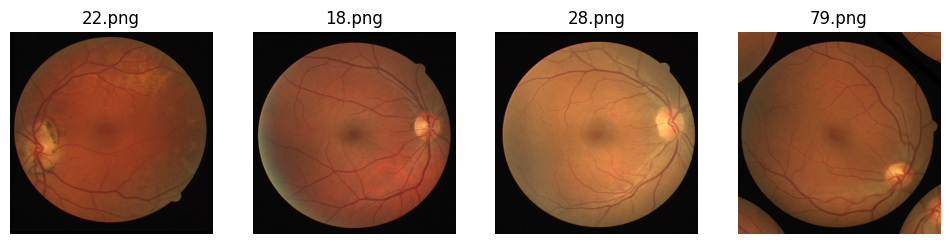

In [61]:
amostras = df_imagens.sample(4)  # visualizando 4 imagens do dataframe

fig, axes = plt.subplots(1, 4, figsize=(12, 6)) #plotando as imagens
for ax, (_, row) in zip(axes, amostras.iterrows()):
    img = Image.open(row["caminho"])  # Abre a imagem
    ax.imshow(img)
    ax.set_title(row["arquivo"])
    ax.axis("off")  # Remove os eixos

plt.show()

Informações complementares, tamanho, pixel e dimensões da figura

In [62]:
print(df_imagens[['largura', 'altura', 'num_pixels']].describe()) #não há variação nas imagens

       largura  altura  num_pixels
count    200.0   200.0       200.0
mean     512.0   512.0    262144.0
std        0.0     0.0         0.0
min      512.0   512.0    262144.0
25%      512.0   512.0    262144.0
50%      512.0   512.0    262144.0
75%      512.0   512.0    262144.0
max      512.0   512.0    262144.0


* Verificando se há imagens corrompidas que não podem abertas ou processadas

In [63]:
def verificar_imagens_corrompidas(caminho_pasta):
    imagens_corrompidas = []

    for raiz, _, arquivos in os.walk(caminho_pasta):  # Percorre recursivamente o diretório do dataset
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(raiz, arquivo)
            try:
                with Image.open(caminho_arquivo) as imagem:  # Tenta abrir cada imagem
                    imagem.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as erro:  # Se ocorrer um erro, a imagem é considerada corrompida
                print(f"Imagem corrompida encontrada: {caminho_arquivo} - Erro: {erro}")
                imagens_corrompidas.append(caminho_arquivo)

    return imagens_corrompidas

# Executa a verificação e exibe o número de imagens corrompidas
imagens_corrompidas = verificar_imagens_corrompidas(path)
print(f"Número de imagens corrompidas: {len(imagens_corrompidas)}")

Número de imagens corrompidas: 0


Distribuição das classes no conjunto de treino: {'image': 80, 'mask': 80}
Distribuição das classes no conjunto de teste: {'image': 20, 'mask': 20}


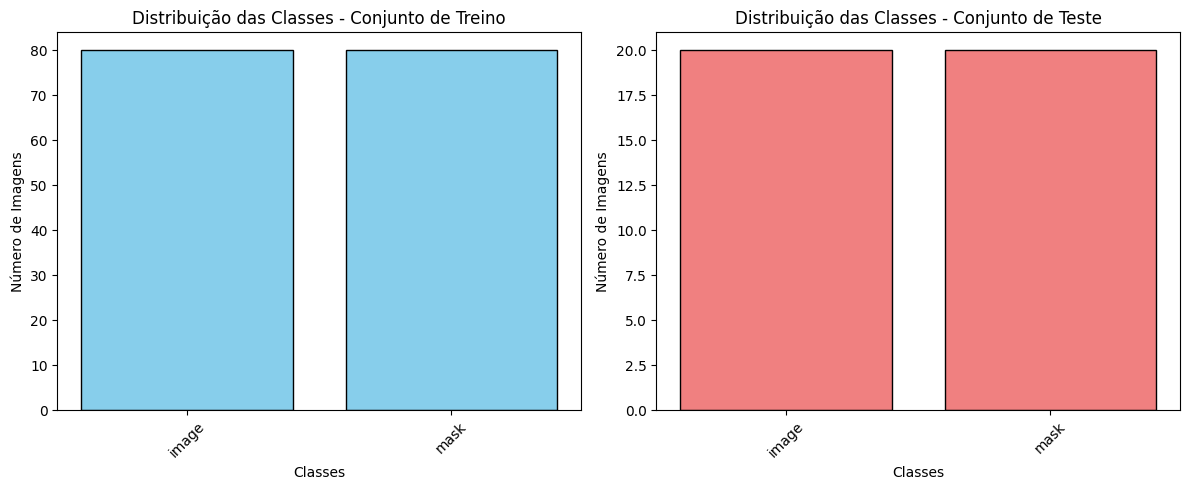

In [64]:
# Função para contar o número de imagens por classe
def contar_imagens_por_classe(caminho_pasta):

    if not os.path.exists(caminho_pasta):  # Verifica se o diretório existe
        print(f"A pasta '{caminho_pasta}' não foi encontrada.")  # Exibe um aviso caso a pasta não exista
        return {}  # Retorna um dicionário vazio

    # Cria um dicionário onde cada chave é uma classe (nome da pasta) e o valor é a quantidade de imagens
    contagem_por_classe = {
        classe: len(os.listdir(os.path.join(caminho_pasta, classe)))
        for classe in os.listdir(caminho_pasta)
        if os.path.isdir(os.path.join(caminho_pasta, classe))  # Considera apenas diretórios
    }

    return contagem_por_classe  # Retorna o dicionário com as contagens

def plotar_distribuicao_classes(contagem_treino, contagem_teste):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Cria uma figura com 2 gráficos lado a lado

    # Gráfico para o conjunto de treino
    axes[0].bar(contagem_treino.keys(), contagem_treino.values(), color='skyblue', edgecolor='black')  # Cria gráfico de barras
    axes[0].set_title("Distribuição das Classes - Conjunto de Treino")  # Define o título do gráfico
    axes[0].set_xlabel("Classes")  # Nomeia o eixo X
    axes[0].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[0].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    # Gráfico para o conjunto de teste
    axes[1].bar(contagem_teste.keys(), contagem_teste.values(), color='lightcoral', edgecolor='black')  # Cria gráfico de barras
    axes[1].set_title("Distribuição das Classes - Conjunto de Teste")  # Define o título do gráfico
    axes[1].set_xlabel("Classes")  # Nomeia o eixo X
    axes[1].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[1].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    plt.show()  # Exibe os gráficos

def main():
    # Contagem das imagens por classe em cada conjunto (treino e teste)
    contagem_treino = contar_imagens_por_classe(pasta_treinamento)
    contagem_teste = contar_imagens_por_classe(pasta_teste)

    if not contagem_treino or not contagem_teste:  # Se não houver imagens em um dos conjuntos
        print("Não foi possível encontrar dados suficientes para análise.")  # Exibe um aviso
        return  # Encerra a execução

    # Exibir contagem das classes no terminal
    print("Distribuição das classes no conjunto de treino:", contagem_treino)
    print("Distribuição das classes no conjunto de teste:", contagem_teste)

    # Gerar os gráficos de distribuição das classes
    plotar_distribuicao_classes(contagem_treino, contagem_teste)


# Garante que o script só será executado se for chamado diretamente (evita execução acidental ao importar como módulo)
if __name__ == "__main__":
    main()

* Conferindo imagens duplicadas que possam enviesar os resultados.
  * Para detectar imagens duplicadas no dataset (mesmo que tenham nomes diferentes), podemos comparar os arquivos pelo hash (assinatura digital) de cada imagem. Isso garante que duas imagens idênticas serão detectadas mesmo que tenham nomes diferentes.

In [65]:
# Importar o módulo defaultdict se ainda não foi importado
from collections import defaultdict

# Função para calcular o hash de uma imagem
def calcular_hash(imagem_path):
    try:
        with Image.open(imagem_path) as img:  # Abre a imagem usando a biblioteca PIL (Pillow)
            img = img.convert("L")  # Converte para escala de cinza para reduzir variações de cor
            return hashlib.md5(img.tobytes()).hexdigest()  # Gera um hash MD5 com os bytes da imagem
    except Exception as e:
        print(f"Erro ao calcular hash para {imagem_path}: {e}")
        return None

# Função para encontrar duplicatas dentro de uma pasta
def encontrar_duplicatas(pasta):
    hashes = defaultdict(list)  # Dicionário onde a chave é o hash e o valor é uma lista de arquivos
    
    # Verificar se a pasta existe
    if not os.path.exists(pasta):
        print(f"Pasta não encontrada: {pasta}")
        return {}
        
    # Percorre todos os arquivos na pasta
    print(f"Verificando duplicatas em: {pasta}")
    for arquivo in tqdm(os.listdir(pasta)):
        caminho_completo = os.path.join(pasta, arquivo)  # Obtém o caminho completo do arquivo
        if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            hash_imagem = calcular_hash(caminho_completo)  # Calcula o hash da imagem
            if hash_imagem:
                hashes[hash_imagem].append(caminho_completo)  # Adiciona o arquivo à lista de imagens com esse hash

    # Dicionário para armazenar apenas os hashes que possuem mais de uma imagem associada
    duplicatas = {}

    # Percorre todos os hashes e suas respectivas listas de arquivos
    for hash_valor, arquivos in hashes.items():
        if len(arquivos) > 1:
            duplicatas[hash_valor] = arquivos

    return duplicatas  # Retorna um dicionário com os arquivos duplicados

# Usar os caminhos definidos anteriormente
pastas_imagem = [pasta_img_treino, pasta_img_teste]
pastas_mask = [pasta_mask_treino, pasta_mask_teste]

# Verificar duplicatas nas imagens
display(md("\n🔍 **Duplicatas em imagens:**"))
total_duplicatas_img = 0
for pasta in pastas_imagem:
    duplicatas = encontrar_duplicatas(pasta)
    if duplicatas:
        total_duplicatas_img += sum(len(files) for files in duplicatas.values())
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():
            display(md(f"  - Hash: {h}"))
            for arq in arquivos:
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))
if total_duplicatas_img == 0:
    display(md("Nenhuma imagem duplicada encontrada no total."))

# Verificar duplicatas nas máscaras
display(md("\n🔍 **Duplicatas em máscaras:**"))
total_duplicatas_mask = 0
for pasta in pastas_mask:
    duplicatas = encontrar_duplicatas(pasta)
    if duplicatas:
        total_duplicatas_mask += sum(len(files) for files in duplicatas.values())
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():
            display(md(f"  - Hash: {h}"))
            for arq in arquivos:
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))
if total_duplicatas_mask == 0:
    display(md("Nenhuma máscara duplicada encontrada no total."))


🔍 **Duplicatas em imagens:**

Verificando duplicatas em: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/image


100%|███████████████████████████████████████████| 80/80 [00:00<00:00, 94.35it/s]


Nenhuma duplicata encontrada em /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/image

Verificando duplicatas em: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/image


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 91.25it/s]



Nenhuma duplicata encontrada em /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/image

Nenhuma imagem duplicada encontrada no total.


🔍 **Duplicatas em máscaras:**

Verificando duplicatas em: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/mask


100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 310.35it/s]



Nenhuma duplicata encontrada em /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/mask

Verificando duplicatas em: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/mask


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 260.83it/s]


Nenhuma duplicata encontrada em /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/mask

Nenhuma máscara duplicada encontrada no total.


Carregando dados de treinamento...
Carregando dados de: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/image e /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/train/mask
Encontrados 80 imagens e 80 máscaras para processar.


 45%|███████████████████▎                       | 36/80 [00:00<00:01, 42.75it/s]

100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 43.39it/s]



Dados de treinamento carregados: (80, 128, 128, 3), (80, 128, 128, 1)
Dataset de treinamento criado com sucesso!

Carregando dados de teste...
Carregando dados de: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/image e /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/mask
Encontrados 20 imagens e 20 máscaras para processar.
Dataset de treinamento criado com sucesso!

Carregando dados de teste...
Carregando dados de: /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/image e /home/delon/Documentos/Data-20250424T151252Z-001/data-science-project/data/test/mask
Encontrados 20 imagens e 20 máscaras para processar.


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 44.42it/s]



Dados de teste carregados: (20, 128, 128, 3), (20, 128, 128, 1)
Dataset de teste criado com sucesso!

Visualizando amostras do dataset de TREINO para verificar o pré-processamento:


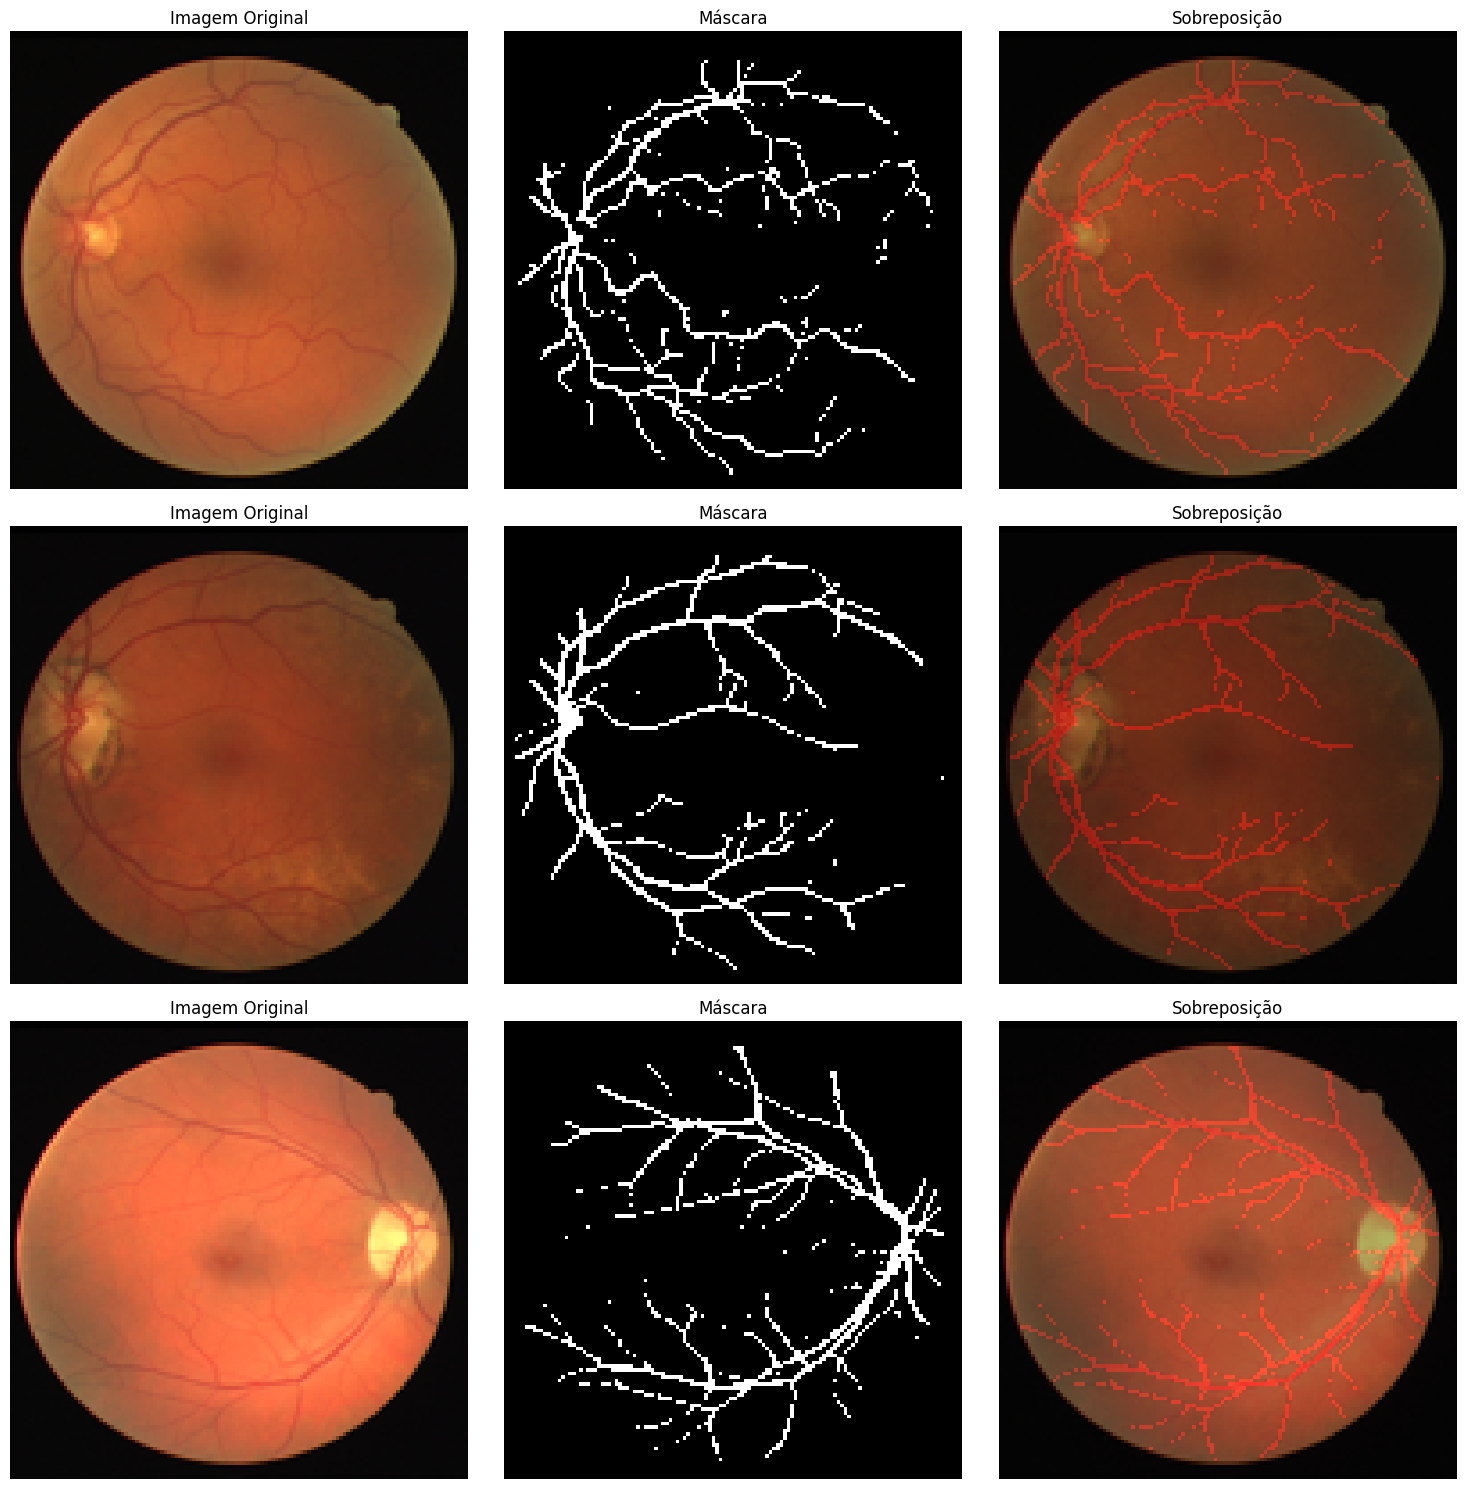

Pré-processamento e criação de datasets concluídos.


In [66]:
# Função de pré-processamento para carregar e redimensionar as imagens
def carregar_e_preprocessar_dados(pasta_imagem, pasta_mascara, tamanho_alvo=(128, 128)):
    # Verificar se as pastas existem
    if not os.path.exists(pasta_imagem):
        raise FileNotFoundError(f"Pasta de imagens não encontrada: {pasta_imagem}")
    if not os.path.exists(pasta_mascara):
        raise FileNotFoundError(f"Pasta de máscaras não encontrada: {pasta_mascara}")

    print(f"Carregando dados de: {pasta_imagem} e {pasta_mascara}")
    imagens = []
    mascaras = []

    # Listar os arquivos nas pastas
    arquivos_imagem = sorted([f for f in os.listdir(pasta_imagem)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    arquivos_mascara = sorted([f for f in os.listdir(pasta_mascara)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    # Garantir que os nomes dos arquivos (sem extensão) correspondem
    nomes_imagem = {os.path.splitext(f)[0] for f in arquivos_imagem}
    nomes_mascara = {os.path.splitext(f)[0] for f in arquivos_mascara}

    if nomes_imagem != nomes_mascara:
        print("Aviso: Nomes de arquivos de imagem e máscara não correspondem perfeitamente!")
        print(f"Imagens extras: {nomes_imagem - nomes_mascara}")
        print(f"Máscaras extras: {nomes_mascara - nomes_imagem}")
        # Continuar apenas com os arquivos que têm par
        arquivos_comuns = nomes_imagem.intersection(nomes_mascara)
        arquivos_imagem = sorted([f for f in arquivos_imagem if os.path.splitext(f)[0] in arquivos_comuns])
        arquivos_mascara = sorted([f for f in arquivos_mascara if os.path.splitext(f)[0] in arquivos_comuns])
        print(f"Processando {len(arquivos_comuns)} pares de arquivos correspondentes.")

    print(f"Encontrados {len(arquivos_imagem)} imagens e {len(arquivos_mascara)} máscaras para processar.")

    # Processar cada par de imagem e máscara
    for arquivo_img, arquivo_mask in tqdm(zip(arquivos_imagem, arquivos_mascara), total=len(arquivos_imagem)):
        try:
            # Carregar imagem e redimensionar
            caminho_imagem = os.path.join(pasta_imagem, arquivo_img)
            img = Image.open(caminho_imagem)
            img = img.resize(tamanho_alvo)
            img_array = np.array(img)

            # Garantir 3 canais (RGB)
            if len(img_array.shape) == 2:
                img_array = np.stack((img_array,) * 3, axis=-1)
            elif img_array.shape[2] == 4: # Remover canal alfa se existir
                 img_array = img_array[:, :, :3]

            # Carregar máscara e redimensionar
            caminho_mascara = os.path.join(pasta_mascara, arquivo_mask)
            mask = Image.open(caminho_mascara)
            mask = mask.resize(tamanho_alvo)
            mask_array = np.array(mask)

            # Converter máscara para binário (0 ou 1)
            if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
                mask_array = np.mean(mask_array, axis=2)
            mask_array = (mask_array > 128).astype(np.float32)

            # Adicionar dimensão de canal se necessário
            if len(mask_array.shape) == 2:
                mask_array = np.expand_dims(mask_array, axis=-1)

            # Normalizar imagem (dividir por 255 para escalar entre 0-1)
            img_array = img_array.astype(np.float32) / 255.0

            # Adicionar aos arrays
            imagens.append(img_array)
            mascaras.append(mask_array)
        except Exception as e:
            print(f"Erro ao processar par {arquivo_img}/{arquivo_mask}: {e}")

    return np.array(imagens), np.array(mascaras)

# Criar datasets do TensorFlow para treinamento e teste
def criar_tf_dataset(imagens, mascaras, tamanho_batch=32, shuffle=True):
    if len(imagens) == 0:
        print("Erro: Não há imagens para criar o dataset.")
        return None
    dataset = tf.data.Dataset.from_tensor_slices((imagens, mascaras))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(imagens))
    dataset = dataset.batch(tamanho_batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Removido: Função encontrar_pastas_dataset e sua chamada
# Removido: Análise de Desbalanceamento de Pixels

# Carregar dados usando os caminhos definidos na célula 9b96b3ad
X_treino, y_treino, X_teste, y_teste = None, None, None, None
treino_dataset, teste_dataset = None, None

if os.path.exists(pasta_img_treino) and os.path.exists(pasta_mask_treino):
    print("\nCarregando dados de treinamento...")
    try:
        X_treino, y_treino = carregar_e_preprocessar_dados(pasta_img_treino, pasta_mask_treino)
        print(f"Dados de treinamento carregados: {X_treino.shape}, {y_treino.shape}")
        treino_dataset = criar_tf_dataset(X_treino, y_treino)
        if treino_dataset:
             print("Dataset de treinamento criado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar ou criar dataset de treino: {e}")
else:
    print("Erro: Pastas de imagens ou máscaras de treinamento não encontradas.")

if os.path.exists(pasta_img_teste) and os.path.exists(pasta_mask_teste):
    print("\nCarregando dados de teste...")
    try:
        X_teste, y_teste = carregar_e_preprocessar_dados(pasta_img_teste, pasta_mask_teste)
        print(f"Dados de teste carregados: {X_teste.shape}, {y_teste.shape}")
        teste_dataset = criar_tf_dataset(X_teste, y_teste, shuffle=False)
        if teste_dataset:
            print("Dataset de teste criado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar ou criar dataset de teste: {e}")
else:
    print("Erro: Pastas de imagens ou máscaras de teste não encontradas.")

# Visualizar algumas imagens para verificar
def visualizar_amostras(dataset, num_amostras=3):
    if dataset is None:
        print("Dataset não disponível para visualização.")
        return
    plt.figure(figsize=(15, 5*num_amostras))
    try:
        for i, (imagens, mascaras) in enumerate(dataset.take(num_amostras)):
            if imagens.shape[0] == 0: continue # Skip empty batches
            imagem = imagens[0].numpy()
            mascara = mascaras[0].numpy()

            # Imagem original
            plt.subplot(num_amostras, 3, i*3+1)
            plt.imshow(imagem)
            plt.title('Imagem Original')
            plt.axis('off')

            # Máscara
            plt.subplot(num_amostras, 3, i*3+2)
            plt.imshow(mascara[:,:,0], cmap='gray')
            plt.title('Máscara')
            plt.axis('off')

            # Sobreposição
            plt.subplot(num_amostras, 3, i*3+3)
            # Garantir que a imagem tem 3 canais para sobreposição
            if imagem.shape[-1] == 1:
                imagem_rgb = np.concatenate([imagem]*3, axis=-1)
            else:
                imagem_rgb = imagem.copy()
            mascara_overlay = np.zeros_like(imagem_rgb)
            mascara_overlay[:,:,0] = mascara[:,:,0] * 1.0  # Canal vermelho
            sobreposicao = np.clip(imagem_rgb * 0.7 + mascara_overlay * 0.3, 0, 1)
            plt.imshow(sobreposicao)
            plt.title('Sobreposição')
            plt.axis('off')
    except Exception as e:
        print(f"Erro durante a visualização: {e}")

    plt.tight_layout()
    plt.show()

# Visualizar alguns exemplos, se o dataset foi criado
if treino_dataset:
    print("\nVisualizando amostras do dataset de TREINO para verificar o pré-processamento:")
    visualizar_amostras(treino_dataset)
    print("Pré-processamento e criação de datasets concluídos.")
elif teste_dataset:
    print("\nVisualizando amostras do dataset de TESTE para verificar o pré-processamento:")
    visualizar_amostras(teste_dataset)
    print("Pré-processamento e criação de datasets concluídos.")
else:
    print("Nenhum dataset disponível para visualização.")

In [67]:
def mobile_encoder_block(inputs, filters, kernel_size=3, strides=1, use_batch_norm=True, dropout_rate=None):
    """Bloco encoder usando convoluções separáveis para eficiência"""
    # Depthwise separable convolution (mais eficiente que convoluções regulares)
    x = layers.SeparableConv2D(filters, kernel_size, padding='same', strides=strides)(inputs)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(alpha=0.1)(x)

    # Segunda convolução separável
    x = layers.SeparableConv2D(filters, kernel_size, padding='same')(x)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(alpha=0.1)(x)

    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

def refinement_module(inputs, skip_connection, filters):
    """Módulo de refinamento para melhorar a detecção de bordas"""
    # Reduz os canais do skip connection para alinhamento
    refined_skip = layers.Conv2D(filters//2, 1, padding='same')(skip_connection)
    refined_skip = layers.BatchNormalization()(refined_skip)
    refined_skip = layers.LeakyReLU(alpha=0.1)(refined_skip)

    # Extrai características de bordas usando filtros de diferentes tamanhos
    edge_detect1 = layers.SeparableConv2D(filters//4, 3, padding='same')(refined_skip)
    edge_detect2 = layers.SeparableConv2D(filters//4, 5, padding='same')(refined_skip)

    # Concatena as características de borda
    edge_features = layers.Concatenate()([edge_detect1, edge_detect2])

    # Combine com o input ascendente
    combined = layers.Concatenate()([inputs, edge_features])

    # Refina as características combinadas
    refined = layers.Conv2D(filters, 1, padding='same')(combined)
    refined = layers.BatchNormalization()(refined)
    refined = layers.LeakyReLU(alpha=0.1)(refined)

    return refined

def spatial_attention(inputs):
    """Mecanismo de atenção espacial para focar em áreas importantes"""
    # Operações de pooling para reduzir dimensionalidade
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(inputs)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(inputs)

    # Concatena os mapas de característica de pooling
    attention = layers.Concatenate()([avg_pool, max_pool])

    # Gera mapa de atenção usando convolução
    attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(attention)

    # Aplica o mapa de atenção aos inputs
    return layers.multiply([inputs, attention])

def unetmer_model(input_size=(128, 128, 3), num_classes=1):
    """UNetMER: UNet with Mobile Encoder and Refinement"""
    inputs = layers.Input(input_size)

    # Encoder (caminho de contração)
    enc1 = mobile_encoder_block(inputs, 64, dropout_rate=0.1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(enc1)

    enc2 = mobile_encoder_block(pool1, 128, dropout_rate=0.1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(enc2)

    enc3 = mobile_encoder_block(pool2, 256, dropout_rate=0.2)
    enc3 = spatial_attention(enc3)  # Aplicação de atenção espacial
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(enc3)

    enc4 = mobile_encoder_block(pool3, 512, dropout_rate=0.2)
    enc4 = spatial_attention(enc4)  # Aplicação de atenção espacial
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bridge
    bridge = mobile_encoder_block(pool4, 1024, dropout_rate=0.3)

    # Decoder (caminho de expansão) com módulos de refinamento
    # Nível 4
    up4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    dec4 = refinement_module(up4, enc4, 512)
    dec4 = mobile_encoder_block(dec4, 512, dropout_rate=0.2)

    # Nível 3
    up3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dec4)
    dec3 = refinement_module(up3, enc3, 256)
    dec3 = mobile_encoder_block(dec3, 256, dropout_rate=0.2)

    # Nível 2
    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dec3)
    dec2 = refinement_module(up2, enc2, 128)
    dec2 = mobile_encoder_block(dec2, 128, dropout_rate=0.1)

    # Nível 1
    up1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dec2)
    dec1 = refinement_module(up1, enc1, 64)
    dec1 = mobile_encoder_block(dec1, 64, dropout_rate=0.1)

    # Camada de saída
    output_layer = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(dec1)

    # Criação do modelo
    model = models.Model(inputs=inputs, outputs=output_layer)
    return model

def compile_unetmer(model, learning_rate=1e-4):
    """Compila o modelo UNetMER com otimizador e métricas apropriadas"""
    # Métricas personalizadas para segmentação
    def dice_coef(y_true, y_pred, smooth=1.0):
        # Converter explicitamente ambos os tensores para float32 para evitar incompatibilidade de tipos
        y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
        y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    def dice_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)

    def bce_dice_loss(y_true, y_pred):
        # Combinação de binary crossentropy e dice loss
        # Garantir que ambos os tensores estejam no mesmo tipo de dados para evitar erros
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    # Configuração do otimizador com learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compilação do modelo
    model.compile(
        optimizer=optimizer,
        loss=bce_dice_loss,
        metrics=[
            dice_coef,
            'binary_accuracy',
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision()
        ]
    )

    return model

def get_improved_callbacks(model_name='unetmer_retina'):
    """Callbacks para monitorar e otimizar o treinamento"""
    # Redução do learning rate se houver estagnação no treinamento
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping para evitar overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Checkpoint para salvar o melhor modelo
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}_best.h5",
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # TensorBoard para visualização do treinamento
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f'./logs/{model_name}',
        histogram_freq=1
    )

    return [reduce_lr, early_stop, checkpoint, tensorboard]

# Instanciar o modelo UNetMER
unetmer = unetmer_model(input_size=(128, 128, 3), num_classes=1)
unetmer = compile_unetmer(unetmer)
# Exibir o resumo do modelo
unetmer.summary()

/home/delon/miniconda3/envs/env_del/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 128, 128,  │        283 │ input_layer_2[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_27 │ (None, 128, 128,  │      4,736 │ leaky_re_lu_26[0… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ leaky_re_lu_27[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_28 │ (None, 64, 64,    │      8,896 │ max_pooling2d_7[… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_29 │ (None, 64, 64,    │     17,664 │ leaky_re_lu_28[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ leaky_re_lu_29[0… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ dropout_10[0][0]

 Total params: 6,456,674 (24.63 MB)

 Trainable params: 6,442,018 (24.57 MB)

 Non-trainable params: 14,656 (57.25 KB)

In [68]:
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    """
    Gerador de dados que carrega imagens e máscaras, com opção de aumentação de dados.
    Compatível com a API de treinamento do Keras.
    """
    def __init__(self, img_dir, mask_dir, batch_size=8, img_size=(128, 128), shuffle=True, augment=True):
        """
        Inicializa o gerador de dados

        Parâmetros:
            img_dir: pasta onde estão as imagens
            mask_dir: pasta onde estão as máscaras
            batch_size: quantidade de imagens processadas em cada lote
            img_size: tamanho das imagens (altura, largura)
            shuffle: se deve embaralhar os dados a cada época
            augment: se deve aplicar técnicas de aumentação de dados
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment

        # Lista todos os arquivos de imagem e máscara
        self.img_files_all = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
        self.mask_files_all = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

        # Garantir correspondência de nomes
        img_names = {os.path.splitext(f)[0] for f in self.img_files_all}
        mask_names = {os.path.splitext(f)[0] for f in self.mask_files_all}
        common_names = img_names.intersection(mask_names)

        self.img_files = sorted([f for f in self.img_files_all if os.path.splitext(f)[0] in common_names])
        self.mask_files = sorted([f for f in self.mask_files_all if os.path.splitext(f)[0] in common_names])

        if len(self.img_files) != len(self.mask_files):
             raise ValueError(f"Número de imagens ({len(self.img_files)}) e máscaras ({len(self.mask_files)}) não correspondem após filtro.")
        if len(self.img_files_all) != len(self.img_files):
             print(f"Aviso: {len(self.img_files_all) - len(self.img_files)} arquivos ignorados por falta de par correspondente.")

        # Cria índices para acesso aleatório
        self.indices = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Retorna o número de lotes por época"""
        return len(self.img_files) // self.batch_size

    def on_epoch_end(self):
        """Embaralha os índices após cada época se shuffle=True"""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        """
        Gera um lote de dados
        """
        # Seleciona índices para o lote atual
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Inicializa arrays vazios para o lote
        batch_imgs = np.zeros((len(batch_indices), *self.img_size, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_indices), *self.img_size, 1), dtype=np.float32)

        # Carrega cada imagem e máscara
        for i, idx in enumerate(batch_indices):
            try:
                # Carrega a imagem
                img_path = os.path.join(self.img_dir, self.img_files[idx])
                img = Image.open(img_path)
                img = img.resize(self.img_size)
                img_array = np.array(img)

                # Garantir 3 canais (RGB)
                if len(img_array.shape) == 2:
                    img_array = np.stack((img_array,) * 3, axis=-1)
                elif img_array.shape[2] == 4:
                    img_array = img_array[:, :, :3]

                # Normalização
                img_array = img_array.astype(np.float32) / 255.0

                # Carrega a máscara
                mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
                mask = Image.open(mask_path)
                mask = mask.resize(self.img_size)
                mask_array = np.array(mask)

                # Processa a máscara para formato binário
                if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
                    mask_array = np.mean(mask_array, axis=2)
                mask_array = (mask_array > 128).astype(np.float32)

                # Adiciona dimensão de canal se necessário
                if len(mask_array.shape) == 2:
                    mask_array = np.expand_dims(mask_array, axis=-1)

                # Armazena no lote
                batch_imgs[i] = img_array
                batch_masks[i] = mask_array
            except Exception as e:
                 print(f"Erro ao carregar/processar índice {idx} ({self.img_files[idx]}): {e}")
                 # Opcional: preencher com zeros ou pular este item
                 batch_imgs[i] = np.zeros((*self.img_size, 3), dtype=np.float32)
                 batch_masks[i] = np.zeros((*self.img_size, 1), dtype=np.float32)

        # Aplica aumentação de dados se habilitado
        if self.augment:
            batch_imgs, batch_masks = self._apply_augmentation(batch_imgs, batch_masks)

        return batch_imgs, batch_masks

    def _apply_augmentation(self, imgs, masks):
        """
        Aplica técnicas de aumentação aos lotes de imagens e máscaras

        Parâmetros:
            imgs: lote de imagens
            masks: lote de máscaras

        Retorna:
            Tupla com imagens e máscaras aumentadas
        """
        for i in range(len(imgs)):
            # Rotação aleatória (50% de chance)
            if np.random.rand() > 0.5:
                angle = np.random.randint(-20, 20)
                imgs[i] = rotate(imgs[i], angle, reshape=False, order=1, mode='nearest')
                masks[i] = rotate(masks[i], angle, reshape=False, order=0, mode='nearest')

            # Espelhamento horizontal (30% de chance)
            if np.random.rand() > 0.7:
                imgs[i] = np.fliplr(imgs[i])
                masks[i] = np.fliplr(masks[i])

            # Ajuste de brilho e contraste (40% de chance)
            if np.random.rand() > 0.6:
                brightness = np.random.uniform(0.8, 1.2)
                imgs[i] = np.clip(imgs[i] * brightness, 0, 1)

            # Zoom aleatório (20% de chance)
            if np.random.rand() > 0.8:
                zoom_factor = np.random.uniform(0.8, 1.2)
                h, w = imgs[i].shape[:2]

                # Aplica zoom às imagens
                zoom_tuple = (zoom_factor,) * 2 + (1,)  # Não aplica zoom no canal de cores
                imgs[i] = self._apply_zoom(imgs[i], zoom_tuple)

                # Aplica o mesmo zoom às máscaras
                mask_zoom = (zoom_factor,) * 2 + (1,)
                masks[i] = self._apply_zoom(masks[i], mask_zoom)

        return imgs, masks

    def _apply_zoom(self, image, zoom_tuple):
        """
        Aplica zoom em uma imagem mantendo suas dimensões originais

        Parâmetros:
            image: imagem a ser processada
            zoom_tuple: fator de zoom para cada dimensão

        Retorna:
            Imagem com zoom aplicado
        """
        h, w = image.shape[:2]

        # Aplica o zoom
        zoomed = zoom(image, zoom_tuple, mode='nearest')

        # Ajusta o tamanho para manter dimensões originais
        zh, zw = zoomed.shape[:2]

        # Se ampliou (zoom > 1), recorta o centro
        if zh > h and zw > w:
            start_h = (zh - h) // 2
            start_w = (zw - w) // 2
            zoomed = zoomed[start_h:start_h+h, start_w:start_w+w]

        # Se reduziu (zoom < 1), preenche as bordas
        elif zh < h or zw < w:
            # Cria uma nova imagem com as dimensões originais
            result = np.zeros_like(image)
            # Calcula onde posicionar a imagem com zoom
            start_h = (h - zh) // 2
            start_w = (w - zw) // 2
            # Insere a imagem com zoom no centro
            result[start_h:start_h+zh, start_w:start_w+zw] = zoomed
            zoomed = result

        # Garantir que a saída tenha a mesma forma da entrada
        if zoomed.shape != image.shape:
             # Tentar redimensionar forçadamente se o recorte/preenchimento falhar
             zoomed = cv2.resize(zoomed, (w, h), interpolation=cv2.INTER_NEAREST)
             # Garantir que a dimensão do canal seja mantida se for máscara
             if len(image.shape) == 3 and image.shape[2] == 1 and len(zoomed.shape) == 2:
                 zoomed = np.expand_dims(zoomed, axis=-1)

        return zoomed

# Criação dos geradores para treino e teste
def criar_geradores(pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste, batch_size=8):
    """
    Cria geradores para os conjuntos de treino e teste
    """
    geradores = {}
    try:
        # Gerador para o conjunto de treino (com aumentação de dados)
        train_generator = AugmentedDataGenerator(
            img_dir=pasta_img_treino,
            mask_dir=pasta_mask_treino,
            batch_size=batch_size,
            img_size=(128, 128),
            shuffle=True,
            augment=True
        )
        geradores['treino'] = train_generator
        print(f"Gerador de treino criado: {len(train_generator.img_files)} imagens, {len(train_generator)} lotes.")
    except Exception as e:
        print(f"Erro ao criar gerador de treino: {e}")

    try:
        # Gerador para o conjunto de teste (sem aumentação)
        test_generator = AugmentedDataGenerator(
            img_dir=pasta_img_teste,
            mask_dir=pasta_mask_teste,
            batch_size=batch_size,
            img_size=(128, 128),
            shuffle=False,
            augment=False
        )
        geradores['teste'] = test_generator
        print(f"Gerador de teste criado: {len(test_generator.img_files)} imagens, {len(test_generator)} lotes.")
    except Exception as e:
        print(f"Erro ao criar gerador de teste: {e}")

    return geradores

# Exemplo de uso:
# Usar os caminhos definidos na célula 9b96b3ad
geradores = {}
if os.path.exists(pasta_img_treino) and os.path.exists(pasta_mask_treino) and os.path.exists(pasta_img_teste) and os.path.exists(pasta_mask_teste):
    geradores = criar_geradores(pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste, batch_size=8)
else:
    print("Erro: Pelo menos uma das pastas (imagem/máscara de treino/teste) não existe. Geradores não criados.")

# Informação sobre os geradores (se criados)
if 'treino' in geradores:
    print(f"Conjunto de treinamento: Aprox. {len(geradores['treino']) * geradores['treino'].batch_size} imagens por época")
if 'teste' in geradores:
    print(f"Conjunto de teste: {len(geradores['teste'].img_files)} imagens no total")

# Verificar se os geradores foram criados antes de prosseguir
if 'treino' not in geradores or 'teste' not in geradores:
    print("\n!!! ERRO CRÍTICO: Geradores não foram criados corretamente. Verifique os caminhos e logs de erro. !!!")

Gerador de treino criado: 80 imagens, 10 lotes.
Gerador de teste criado: 20 imagens, 2 lotes.
Conjunto de treinamento: Aprox. 80 imagens por época
Conjunto de teste: 20 imagens no total


In [69]:
#Treinar o modelo UNetMER
history_unetmer = None # Inicializar
if 'treino' in geradores and 'teste' in geradores:
    print("Iniciando treinamento do UNetMER...")
    EPOCHS = 50 # Número de épocas
    try:
        history_unetmer = unetmer.fit(
             geradores['treino'],
             epochs=EPOCHS,
             validation_data=geradores['teste'],
             callbacks=get_improved_callbacks() # Adicionar callbacks
        )
        print("Treinamento concluído.")
    except Exception as e:
        print(f"Erro durante o treinamento: {e}")
else:
    print("Erro: Geradores de treino ou teste não estão disponíveis. Treinamento cancelado.")

# Função de avaliação (mantida como antes, mas com verificações)
def evaluate_unetmer(model, test_generator, num_samples=5):
    if test_generator is None:
        print("Erro: Gerador de teste não disponível para avaliação.")
        return
    if len(test_generator) == 0:
        print("Aviso: Gerador de teste está vazio. Avaliação pulada.")
        return

    """
    Avalia e visualiza os resultados do modelo UNetMER
    """
    # Avaliar o modelo no conjunto de teste
    print("\nAvaliando modelo no conjunto de teste...")
    try:
        test_results = model.evaluate(test_generator, verbose=1)
        print("\nResultados da avaliação do UNetMER:")
        metrics_dict = dict(zip(model.metrics_names, test_results))
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")
    except Exception as e:
        print(f"Erro durante a avaliação: {e}")
        return

    # Obter um batch de dados para visualização e matriz de confusão
    print("\nObtendo batch de teste para visualização...")
    try:
        x_batch, y_batch = next(iter(test_generator))
        if x_batch.shape[0] == 0:
             print("Gerador retornou um batch vazio. Pulando visualização.")
             return
    except StopIteration:
        print("Gerador de teste esgotado ou vazio. Não é possível visualizar.")
        return
    except Exception as e:
        print(f"Erro ao obter batch do gerador: {e}")
        return

    # Fazer previsões com o modelo
    print("Realizando previsões...")
    try:
        predictions_prob = model.predict(x_batch)
    except Exception as e:
        print(f"Erro durante a predição: {e}")
        return

    # Binarizar as previsões para visualização e métricas
    limiar = 0.5
    print(f"Usando limiar de {limiar} para binarização.")
    predictions_binary = (predictions_prob > limiar).astype(np.float32)

    # Visualizar algumas previsões
    print("Gerando visualizações...")
    num_to_show = min(num_samples, len(x_batch))
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 5 * num_to_show))
    if num_to_show == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_to_show):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara Prevista (Probabilidades)
        im = axes[i, 2].imshow(predictions_prob[i, :, :, 0], cmap='viridis', vmin=0, vmax=1)
        axes[i, 2].set_title('Previsão (Probabilidades)')
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        # Máscara Prevista (Binarizada)
        axes[i, 3].imshow(predictions_binary[i, :, :, 0], cmap='gray')
        axes[i, 3].set_title(f'Previsão Binarizada (limiar={limiar})')
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

    # Calcular e visualizar a matriz de confusão (usando todo o batch)
    print("\nCalculando Matriz de Confusão (baseada no batch visualizado)...")
    y_true_flat = (y_batch.flatten() > 0.5).astype(int)
    y_pred_flat = (predictions_prob.flatten() > limiar).astype(int)

    unique_true = np.unique(y_true_flat)
    unique_pred = np.unique(y_pred_flat)
    print(f"Valores únicos em y_true_flat: {unique_true}")
    print(f"Valores únicos em y_pred_flat: {unique_pred}")

    try:
        # Especificar labels para garantir formato 2x2 mesmo se uma classe faltar
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
        print("Matriz de Confusão (Fundo=0, Vaso=1):\n", cm)

        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fundo', 'Vaso'])
        disp.plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - UNetMER (limiar={limiar})')
        plt.show()

        # Calcular métricas apenas se a matriz for 2x2
        if cm.shape == (2, 2):
            print("\nMétricas de avaliação detalhadas (baseadas no batch):")
            tn, fp, fn, tp = cm.ravel()
            precision_val = tp / (tp + fp + 1e-7)
            recall_val = tp / (tp + fn + 1e-7)
            f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-7)
            accuracy_val = (tp + tn) / (tp + tn + fp + fn + 1e-7)
            print(f"Acurácia: {accuracy_val:.4f}")
            print(f"Precisão (Vaso): {precision_val:.4f}")
            print(f"Recall (Sensibilidade Vaso): {recall_val:.4f}")
            print(f"F1-Score (Vaso): {f1_score_val:.4f}")
        else:
            print("Matriz de confusão não tem formato 2x2, métricas detalhadas não calculadas.")

    except ValueError as e:
        print(f"Erro ao calcular ou plotar matriz de confusão: {e}")

# Plotar histórico de treinamento (versão corrigida)
def plot_unetmer_training_history(history):
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Histórico de treinamento não disponível para plotar.")
        return

    # ... (restante da função plot_unetmer_training_history permanece igual)
    # Primeiro, vamos verificar quais métricas estão disponíveis no histórico
    print("\nPlotando histórico de treinamento...")
    print("Métricas disponíveis no histórico:", list(history.history.keys()))

    # Definir mapeamentos para métricas possíveis (nomes comuns no Keras)
    metric_mappings = {
        'loss': 'loss',
        'dice_coef': 'dice_coef',  # Nossa métrica personalizada
        'binary_accuracy': ['binary_accuracy', 'accuracy'],  # Possíveis nomes para acurácia
        'recall': ['recall', 'recall_1', 'recall_2', 'recall_3'],  # Possíveis nomes para recall
        'precision': ['precision', 'precision_1', 'precision_2', 'precision_3']  # Possíveis nomes para precisão
    }

    # Encontrar os nomes reais no histórico
    available_metrics = {}
    for key, possible_names in metric_mappings.items():
        if isinstance(possible_names, list):
            for name in possible_names:
                # Check for train metric
                if name in history.history and f'val_{name}' in history.history:
                    available_metrics[key] = name
                    break
        else:
             # Check for train metric
            if possible_names in history.history and f'val_{possible_names}' in history.history:
                available_metrics[key] = possible_names

    # Exibir as métricas disponíveis encontradas que serão plotadas
    print("Métricas mapeadas para plotagem (treino e validação disponíveis):", available_metrics)

    # Definir métricas e títulos para plotar (apenas as disponíveis com treino e validação)
    metrics_to_plot = []
    titles_to_plot = []

    if 'loss' in available_metrics:
        metrics_to_plot.append(available_metrics['loss'])
        titles_to_plot.append('Loss (BCE + Dice)')

    if 'dice_coef' in available_metrics:
        metrics_to_plot.append(available_metrics['dice_coef'])
        titles_to_plot.append('Dice Coefficient')

    if 'binary_accuracy' in available_metrics:
        metrics_to_plot.append(available_metrics['binary_accuracy'])
        titles_to_plot.append('Acurácia Binária')

    if 'recall' in available_metrics:
        metrics_to_plot.append(available_metrics['recall'])
        titles_to_plot.append('Recall (Vaso)')

    if 'precision' in available_metrics:
        metrics_to_plot.append(available_metrics['precision'])
        titles_to_plot.append('Precision (Vaso)')

    # Criar subplots dinâmicos baseados no número de métricas disponíveis
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0:
        print("Nenhuma métrica válida com dados de treino e validação encontrada no histórico para plotar.")
        return
Principais características:

    Inicialização:
        Recebe diretórios de imagens e máscaras
        Verifica correspondência entre pares de imagens e máscaras
        Inicializa índices para acesso aleatório

    Carregamento de dados:
        Redimensiona imagens e máscaras para tamanho uniforme
        Normaliza imagens (divide por 255)Principais características:

    Inicialização:
        Recebe diretórios de imagens e máscaras
        Verifica correspondência entre pares de imagens e máscaras
        Inicializa índices para acesso aleatório

    Carregamento de dados:
        Redimensiona imagens e máscaras para tamanho uniforme
        Normaliza imagens (divide por 255)
        Converte máscaras para formato binário (0 ou 1)
        Gerencia diferentes formatos de imagem (RGB, escala de cinza)

    Aumentação de dados:
        Rotação aleatória (±20 graus, 50% de chance)
        Espelhamento horizontal (30% de chance)
        Ajustes de brilho (40% de chance)
        Zoom aleatório (20% de chance)

        Converte máscaras para formato binário (0 ou 1)
        Gerencia diferentes formatos de imagem (RGB, escala de cinza)

    Aumentação de dados:
        Rotação aleatória (±20 graus, 50% de chance)
        Espelhamento horizontal (30% de chance)
        Ajustes de brilho (40% de chance)
        Zoom aleatório (20% de chance)

    # Calcular layout ideal para os subplots
    cols = min(3, n_metrics)
    rows = (n_metrics + cols - 1) // cols  # Arredondar para cima: (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if n_metrics == 1:  # Caso especial para apenas uma métrica
        axes = np.array([axes])
    axes = axes.flatten()

    # Plotar cada métrica
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles_to_plot)):
        if i < len(axes):
            axes[i].plot(history.history[metric], label=f'Treino')
            val_metric = f'val_{metric}'
            # We already checked val_metric exists
            axes[i].plot(history.history[val_metric], label=f'Validação')
            axes[i].set_title(title)
            axes[i].set_xlabel('Época')
            axes[i].set_ylabel(title)
            axes[i].legend()

    # Desativar eixos extras não utilizados
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devido a erros anteriores.")

Iniciando treinamento do UNetMER...


/home/delon/miniconda3/envs/env_del/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.4004 - dice_coef: 0.1326 - loss: 1.6556 - precision_1: 0.2564 - recall_1: 0.5636
Epoch 1: val_dice_coef improved from -inf to 0.12742, saving model to unetmer_retina_best.h5

Epoch 1: val_dice_coef improved from -inf to 0.12742, saving model to unetmer_retina_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - binary_accuracy: 0.4004 - dice_coef: 0.1328 - loss: 1.6540 - precision_1: 0.2581 - recall_1: 0.5637 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.1274 - val_loss: 1.5630 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.4768 - dice_coef: 0.1396 - loss: 1.5676 - precision_1: 0.2178 - recall_1: 0.5563
Epoch 2: val_dice_coef did not improve from 0.12742

Epoch 2: val_dice_coef did not improve from 0.12742
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - binary_accuracy: 0.4798 - dice_coef: 0.1395 - loss: 1.5655 - precision_1: 0.2164 - recall_1: 0.5545 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.1274 - val_loss: 1.5605 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - binary_accuracy: 0.4798 - dice_coef: 0.1395 - loss: 1.5655 - precision_1: 0.2164 -

: 

: 

: 


Avaliando o modelo UNetMER final...

Avaliando modelo no conjunto de teste...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - binary_accuracy: 0.9294 - dice_coef: 0.1394 - loss: 1.1003 - precision: 0.9119 - recall: 0.0370

Resultados da avaliação do UNetMER:
loss: 1.1052
compile_metrics: 0.1362

Obtendo batch de teste para visualização...
Realizando previsões...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Usando limiar de 0.15 para binarização.
Gerando visualizações...


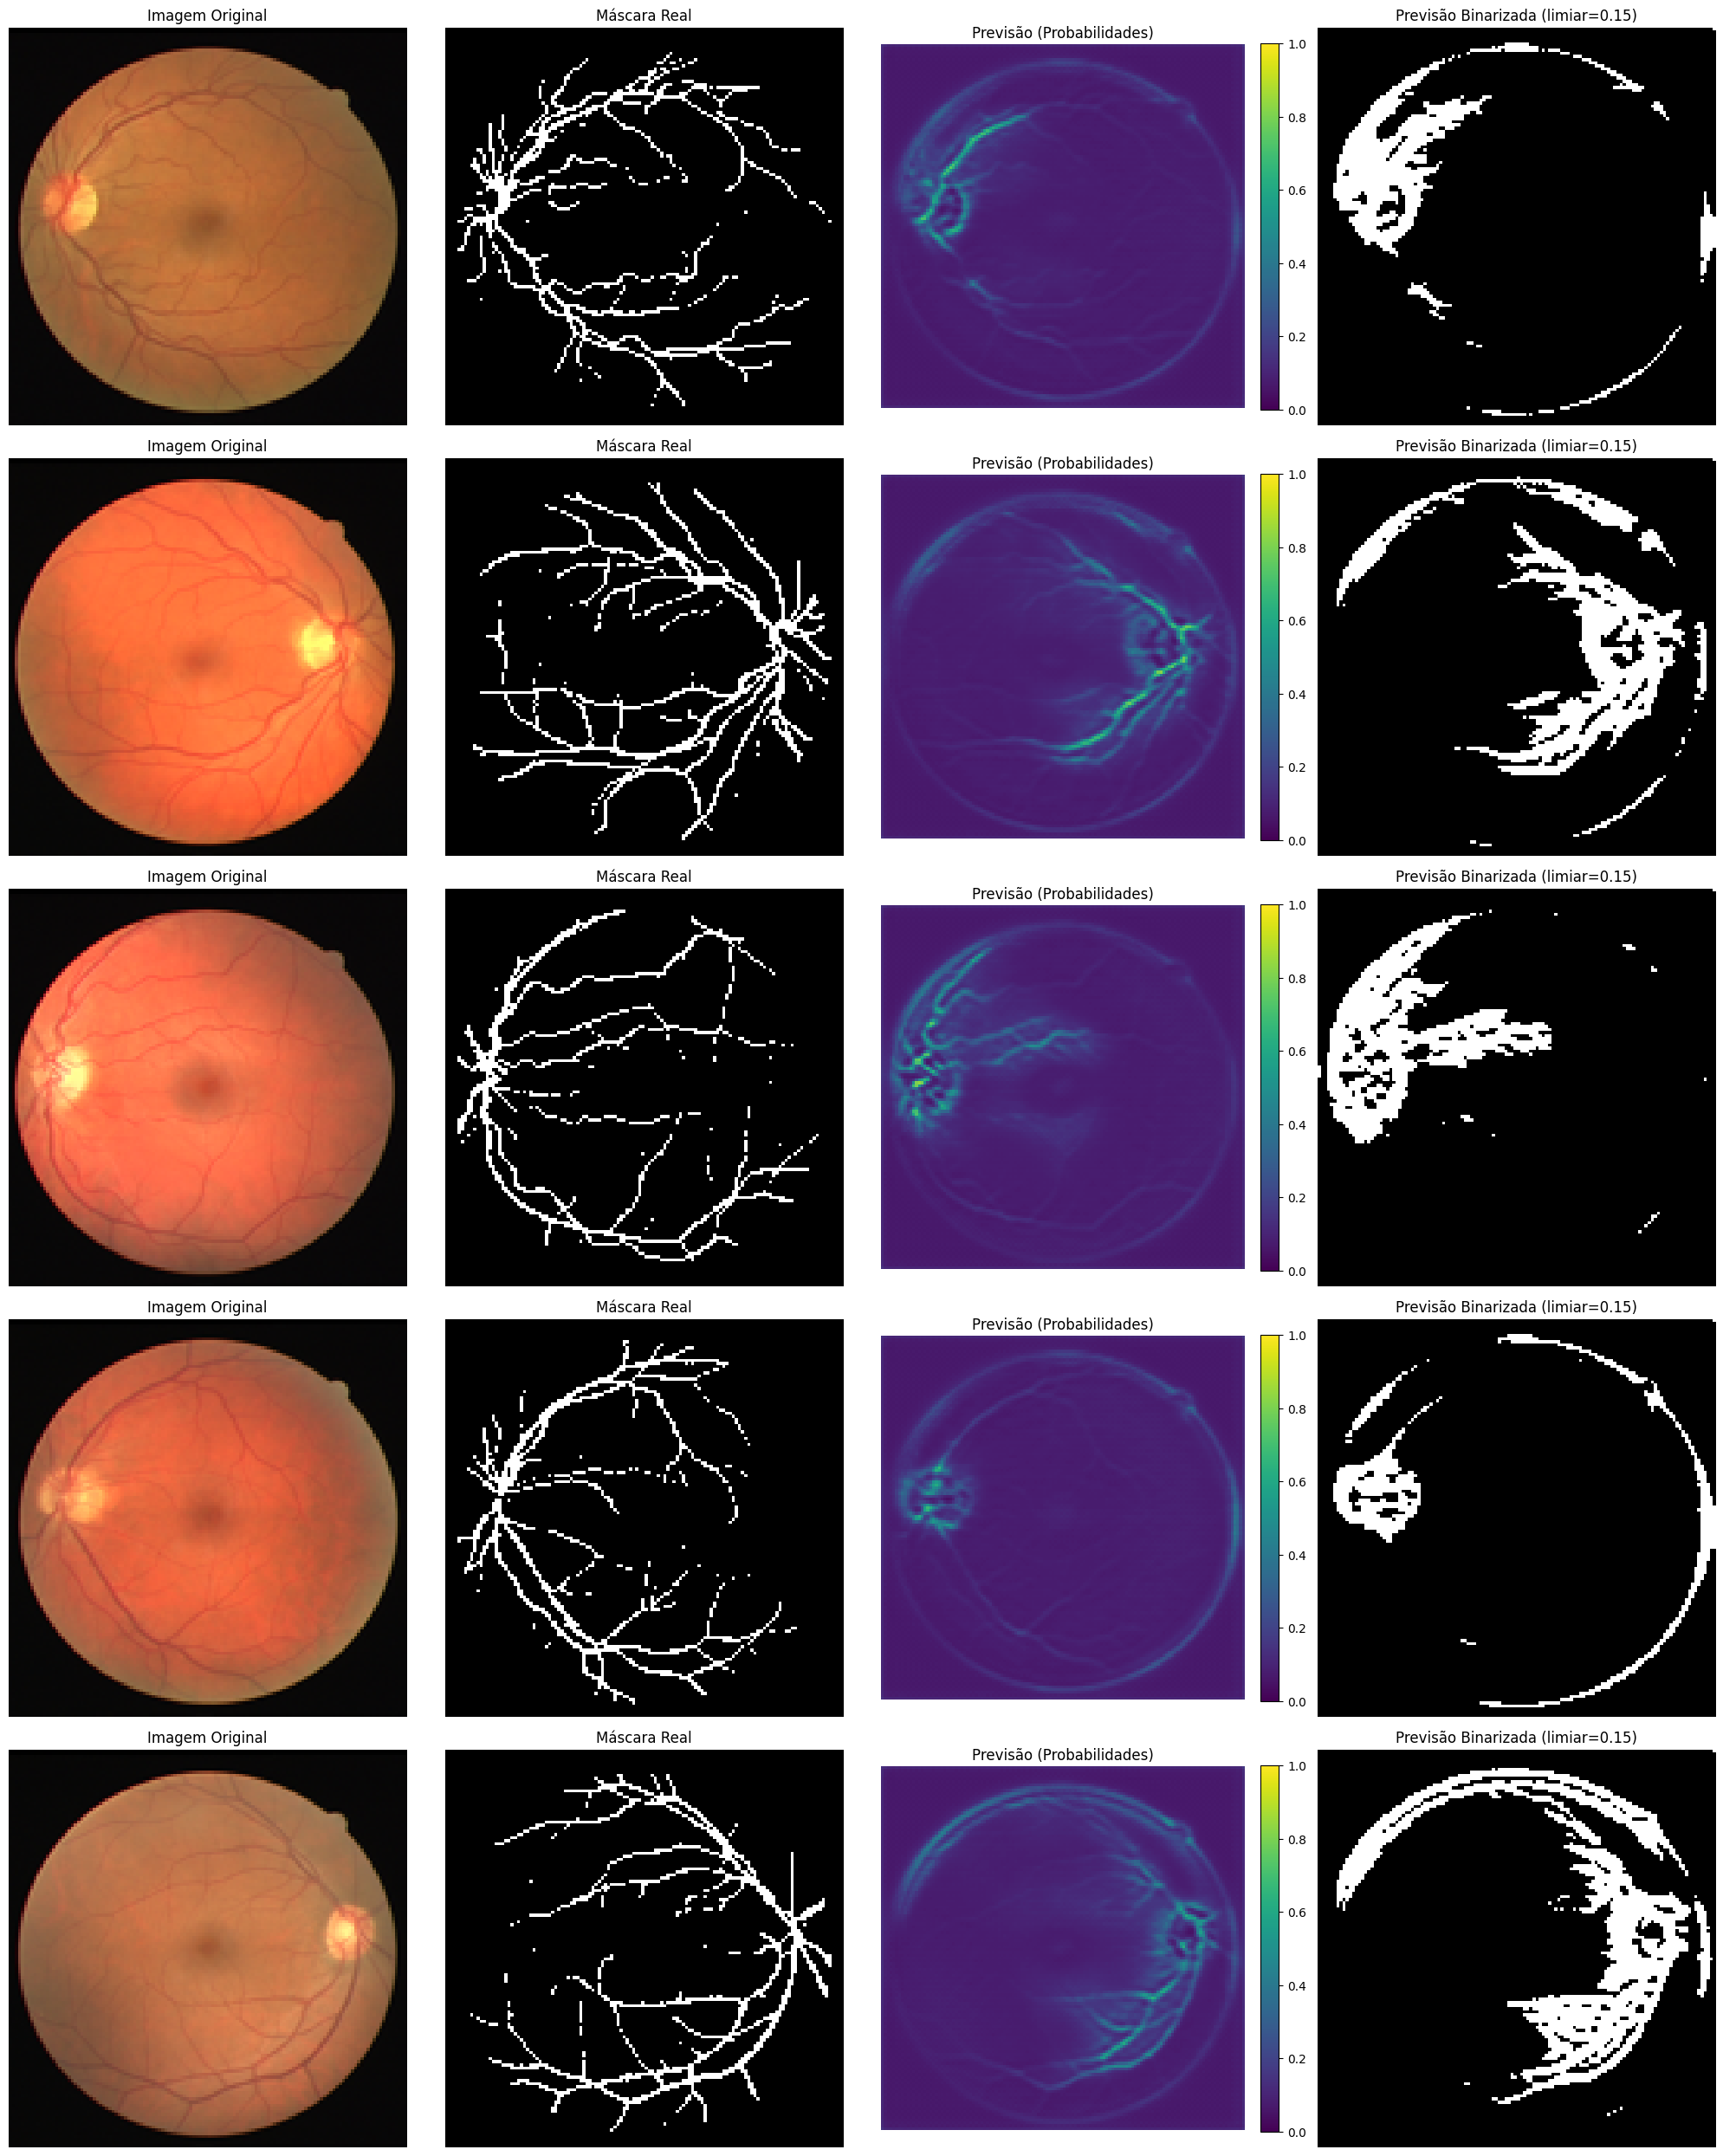


Calculando Matriz de Confusão (baseada no batch visualizado)...
Valores únicos em y_true_flat: [0 1]
Valores únicos em y_pred_flat: [0 1]
Matriz de Confusão (Fundo=0, Vaso=1):
 [[111764   9732]
 [  6189   3387]]


<Figure size 800x600 with 0 Axes>

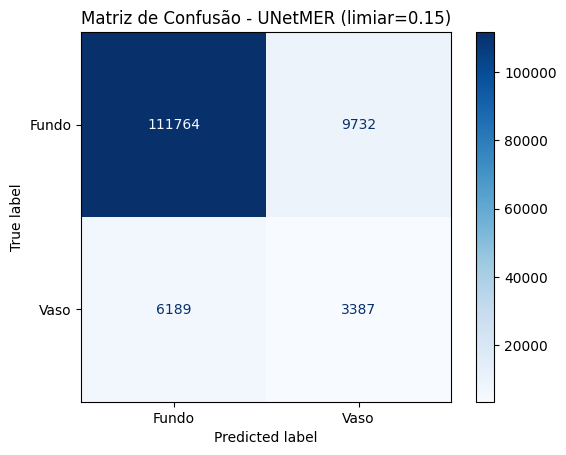


Métricas de avaliação detalhadas (baseadas no batch):
Acurácia: 0.8785
Precisão (Vaso): 0.2582
Recall (Sensibilidade Vaso): 0.3537
F1-Score (Vaso): 0.2985

Plotando histórico de treinamento...
Métricas disponíveis no histórico: ['binary_accuracy', 'dice_coef', 'loss', 'precision', 'recall', 'val_binary_accuracy', 'val_dice_coef', 'val_loss', 'val_precision', 'val_recall', 'learning_rate']
Métricas mapeadas para plotagem (treino e validação disponíveis): {'loss': 'loss', 'dice_coef': 'dice_coef', 'binary_accuracy': 'binary_accuracy', 'recall': 'recall', 'precision': 'precision'}


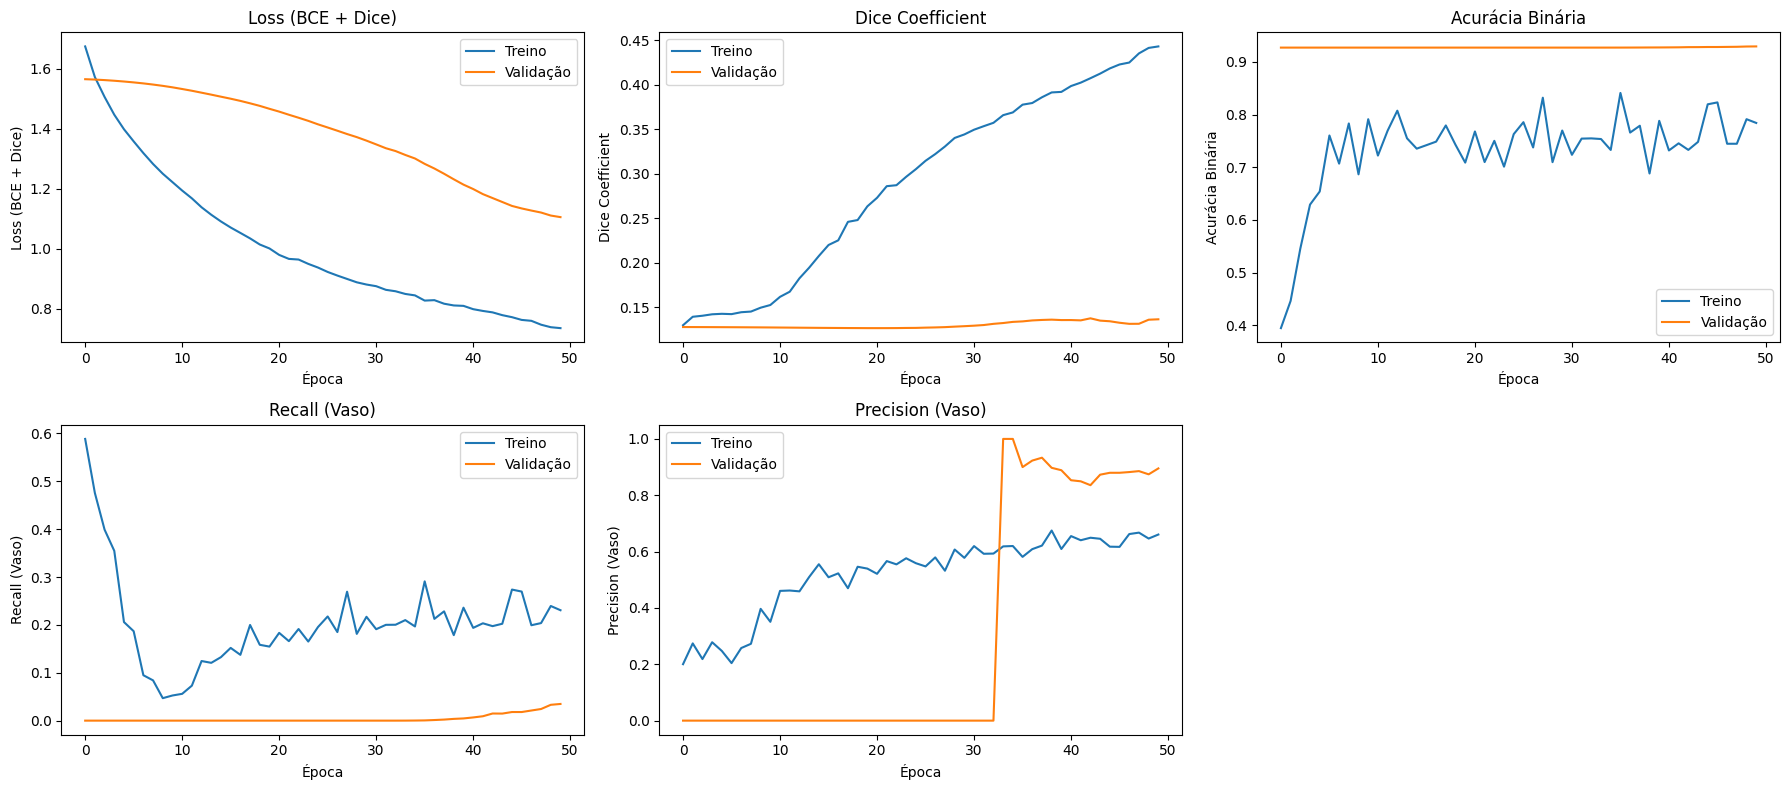

In [ ]:
def evaluate_unetmer(model, test_generator, num_samples=5):
    if test_generator is None:
        print("Erro: Gerador de teste não disponível para avaliação.")
        return
    if len(test_generator) == 0:
        print("Aviso: Gerador de teste está vazio. Avaliação pulada.")
        return

    """
    Avalia e visualiza os resultados do modelo UNetMER
    """
    # Avaliar o modelo no conjunto de teste
    print("\nAvaliando modelo no conjunto de teste...")
    try:
        test_results = model.evaluate(test_generator, verbose=1)
        print("\nResultados da avaliação do UNetMER:")
        metrics_dict = dict(zip(model.metrics_names, test_results))
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")
    except Exception as e:
        print(f"Erro durante a avaliação: {e}")
        return

    # Obter um batch de dados para visualização e matriz de confusão
    print("\nObtendo batch de teste para visualização...")
    try:
        x_batch, y_batch = next(iter(test_generator))
        if x_batch.shape[0] == 0:
             print("Gerador retornou um batch vazio. Pulando visualização.")
             return
    except StopIteration:
        print("Gerador de teste esgotado ou vazio. Não é possível visualizar.")
        return
    except Exception as e:
        print(f"Erro ao obter batch do gerador: {e}")
        return

    # Fazer previsões com o modelo
    print("Realizando previsões...")
    try:
        predictions_prob = model.predict(x_batch)
    except Exception as e:
        print(f"Erro durante a predição: {e}")
        return

    # Binarizar as previsões para visualização e métricas
    limiar = 0.15
    print(f"Usando limiar de {limiar} para binarização.")
    predictions_binary = (predictions_prob > limiar).astype(np.float32)

    # Visualizar algumas previsões
    print("Gerando visualizações...")
    num_to_show = min(num_samples, len(x_batch))
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 5 * num_to_show))
    if num_to_show == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_to_show):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara Prevista (Probabilidades)
        im = axes[i, 2].imshow(predictions_prob[i, :, :, 0], cmap='viridis', vmin=0, vmax=1)
        axes[i, 2].set_title('Previsão (Probabilidades)')
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        # Máscara Prevista (Binarizada)
        axes[i, 3].imshow(predictions_binary[i, :, :,0], cmap='gray')
        axes[i, 3].set_title(f'Previsão Binarizada (limiar={limiar})')
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

    # Calcular e visualizar a matriz de confusão (usando todo o batch)
    print("\nCalculando Matriz de Confusão (baseada no batch visualizado)...")
    y_true_flat = (y_batch.flatten() > 0.5).astype(int)
    y_pred_flat = (predictions_prob.flatten() > limiar).astype(int)

    unique_true = np.unique(y_true_flat)
    unique_pred = np.unique(y_pred_flat)
    print(f"Valores únicos em y_true_flat: {unique_true}")
    print(f"Valores únicos em y_pred_flat: {unique_pred}")

    try:
        # Especificar labels para garantir formato 2x2 mesmo se uma classe faltar
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
        print("Matriz de Confusão (Fundo=0, Vaso=1):\n", cm)

        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fundo', 'Vaso'])
        disp.plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - UNetMER (limiar={limiar})')
        plt.show()

        # Calcular métricas apenas se a matriz for 2x2
        if cm.shape == (2, 2):
            print("\nMétricas de avaliação detalhadas (baseadas no batch):")
            tn, fp, fn, tp = cm.ravel()
            precision_val = tp / (tp + fp + 1e-7)
            recall_val = tp / (tp + fn + 1e-7)
            f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-7)
            accuracy_val = (tp + tn) / (tp + tn + fp + fn + 1e-7)
            print(f"Acurácia: {accuracy_val:.4f}")
            print(f"Precisão (Vaso): {precision_val:.4f}")
            print(f"Recall (Sensibilidade Vaso): {recall_val:.4f}")
            print(f"F1-Score (Vaso): {f1_score_val:.4f}")
        else:
            print("Matriz de confusão não tem formato 2x2, métricas detalhadas não calculadas.")

    except ValueError as e:
        print(f"Erro ao calcular ou plotar matriz de confusão: {e}")

# Plotar histórico de treinamento (versão corrigida)
def plot_unetmer_training_history(history):
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Histórico de treinamento não disponível para plotar.")
        return

    # ... (restante da função plot_unetmer_training_history permanece igual)
    # Primeiro, vamos verificar quais métricas estão disponíveis no histórico
    print("\nPlotando histórico de treinamento...")
    print("Métricas disponíveis no histórico:", list(history.history.keys()))

    # Definir mapeamentos para métricas possíveis (nomes comuns no Keras)
    metric_mappings = {
        'loss': 'loss',
        'dice_coef': 'dice_coef',  # Nossa métrica personalizada
        'binary_accuracy': ['binary_accuracy', 'accuracy'],  # Possíveis nomes para acurácia
        'recall': ['recall', 'recall_1', 'recall_2', 'recall_3'],  # Possíveis nomes para recall
        'precision': ['precision', 'precision_1', 'precision_2', 'precision_3']  # Possíveis nomes para precisão
    }

    # Encontrar os nomes reais no histórico
    available_metrics = {}
    for key, possible_names in metric_mappings.items():
        if isinstance(possible_names, list):
            for name in possible_names:
                # Check for train metric
                if name in history.history and f'val_{name}' in history.history:
                    available_metrics[key] = name
                    break
        else:
             # Check for train metric
            if possible_names in history.history and f'val_{possible_names}' in history.history:
                available_metrics[key] = possible_names

    # Exibir as métricas disponíveis encontradas que serão plotadas
    print("Métricas mapeadas para plotagem (treino e validação disponíveis):", available_metrics)

    # Definir métricas e títulos para plotar (apenas as disponíveis com treino e validação)
    metrics_to_plot = []
    titles_to_plot = []

    if 'loss' in available_metrics:
        metrics_to_plot.append(available_metrics['loss'])
        titles_to_plot.append('Loss (BCE + Dice)')

    if 'dice_coef' in available_metrics:
        metrics_to_plot.append(available_metrics['dice_coef'])
        titles_to_plot.append('Dice Coefficient')

    if 'binary_accuracy' in available_metrics:
        metrics_to_plot.append(available_metrics['binary_accuracy'])
        titles_to_plot.append('Acurácia Binária')

    if 'recall' in available_metrics:
        metrics_to_plot.append(available_metrics['recall'])
        titles_to_plot.append('Recall (Vaso)')

    if 'precision' in available_metrics:
        metrics_to_plot.append(available_metrics['precision'])
        titles_to_plot.append('Precision (Vaso)')

    # Criar subplots dinâmicos baseados no número de métricas disponíveis
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0:
        print("Nenhuma métrica válida com dados de treino e validação encontrada no histórico para plotar.")
        return

    # Calcular layout ideal para os subplots
    cols = min(3, n_metrics)
    rows = (n_metrics + cols - 1) // cols  # Arredondar para cima: (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if n_metrics == 1:  # Caso especial para apenas uma métrica
        axes = np.array([axes])
    axes = axes.flatten()

    # Plotar cada métrica
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles_to_plot)):
        if i < len(axes):
            axes[i].plot(history.history[metric], label=f'Treino')
            val_metric = f'val_{metric}'
            # We already checked val_metric exists
            axes[i].plot(history.history[val_metric], label=f'Validação')
            axes[i].set_title(title)
            axes[i].set_xlabel('Época')
            axes[i].set_ylabel(title)
            axes[i].legend()

    # Desativar eixos extras não utilizados
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devido a erros anteriores.")